In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from dotenv import load_dotenv
from langchain_openai import AzureChatOpenAI
from pydantic import BaseModel, Field

In [2]:
load_dotenv()  # Load environment variables from .env file
model=AzureChatOpenAI(model="gpt-4o-mini")

In [3]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="The sentiment of the review")

In [4]:
structured_model = model.with_structured_output(SentimentSchema)

In [5]:
prompt="What is the sentiment of the following review? 'the software is aveerage and crashes often'"
structured_model.invoke(prompt)

SentimentSchema(sentiment='negative')

In [7]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [8]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["bug", "feature-request", "performance", "usability"] = Field(description="Type of issue identified in the review")
    tone: Literal["angry", "frustrated", "neutral", "happy"] = Field(description="Tone of the review")
    urgency: Literal["low", "medium", "high", "critical"] = Field(description="Urgency level of the issue")

In [9]:
structured_diagnosis_model = model.with_structured_output(DiagnosisSchema)

In [10]:
def find_sentiment(state: ReviewState) -> ReviewState:
    review = state['review']
    prompt = f"What is the sentiment of the following review? '{review}'"
    result = structured_model.invoke(prompt)
    return {'sentiment': result.sentiment}

def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:
    sentiment = state['sentiment']
    if sentiment == "positive":
        return "positive_response"
    else:
        return "run_diagnosis"
    
def positive_response(state: ReviewState) -> ReviewState:
    prompt=f"Write a warm thank you response to the following positive review: '{state['review']}' \n Also kindly ask user to leave us the feedbcak on our website."
    response = model.invoke(prompt)
    return {'response': response}

def run_diagnosis(state: ReviewState) -> ReviewState:
    prompt=f"Diagnose the issue with the following negative review: '{state['review']}'"
    response = structured_diagnosis_model.invoke(prompt)
    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState) -> ReviewState:
    diagnosis = state['diagnosis']
    prompt=f"Based on the following diagnosis '{diagnosis}', write a sympathetic response to the user review: '{state['review']}'"
    response = model.invoke(prompt)
    return {'response': response}

In [11]:
graph=StateGraph(ReviewState)
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('negative_response', negative_response)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow=graph.compile()

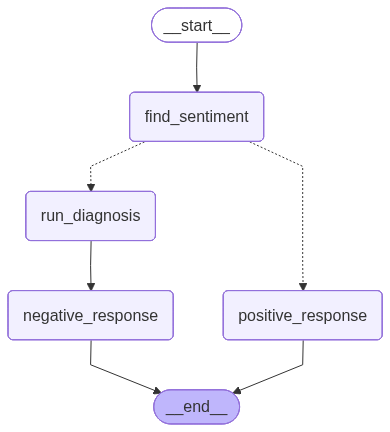

In [12]:
workflow

In [21]:
initial_state={'review': "The product is too buggy and crashes frequently!"}
result=workflow.invoke(initial_state)
print(result)

{'review': 'The product is too buggy and crashes frequently!', 'sentiment': 'negative', 'diagnosis': {'issue_type': 'bug', 'tone': 'frustrated', 'urgency': 'high'}, 'response': AIMessage(content='Subject: We’re Here to Help!\n\nHi there,\n\nThank you for taking the time to share your experience with us. I completely understand how frustrating it can be when a product doesn’t work as it should, especially when it crashes frequently. Your feedback is incredibly valuable, and I want you to know that we take these issues very seriously.\n\nWe’re currently aware of these bugs and are actively working on fixes to improve the stability of our product. I appreciate your patience as we work through these challenges. In the meantime, if you could provide us with any specific details about when the crashes occur, it would greatly assist our team in addressing the problem more effectively.\n\nPlease know that your experience matters to us, and we are committed to resolving this as quickly as possi